In [ ]:
import nltk
nltk.download('all')

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import VotingClassifier

In [3]:
# Load the dataset
data = pd.read_csv('/content/English.csv')

In [4]:
# Data Cleaning
lemmatizer = WordNetLemmatizer()
stopwords = set(stopwords.words('english'))

def clean_text(text):
    # Remove punctuations
    text = re.sub('[^\w\s]','', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords])
    # Lemmatize
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

data['tweet'] = data['tweet'].apply(lambda x: clean_text(x))

In [5]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['tweet'], data['label'], test_size=0.2)

In [6]:
# TF-IDF feature extraction
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [7]:
# Feature selection using Chi-Square
selector = SelectKBest(chi2, k=min(500, X_train_tfidf.shape[1]))
selector.fit(X_train_tfidf, y_train)
X_train_tfidf = selector.transform(X_train_tfidf)
X_test_tfidf = selector.transform(X_test_tfidf)

In [8]:
# Create individual classifiers
ada = AdaBoostClassifier(n_estimators=100, random_state=0)
nb = MultinomialNB()
ridge = RidgeClassifier()
gb = GradientBoostingClassifier()
X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()
lda = LinearDiscriminantAnalysis()


In [9]:
# Create a list of classifiers
classifiers = [('ada', ada), ('nb', nb), ('ridge', ridge), ('gb', gb), ('lda', lda)] #


In [10]:
# Create the ensemble model
ensemble = VotingClassifier(classifiers, voting='hard')

In [11]:
# Fit the ensemble model on the training data
ensemble.fit(X_train_tfidf, y_train)

VotingClassifier(estimators=[('ada',
                              AdaBoostClassifier(n_estimators=100,
                                                 random_state=0)),
                             ('nb', MultinomialNB()),
                             ('ridge', RidgeClassifier()),
                             ('gb', GradientBoostingClassifier()),
                             ('lda', LinearDiscriminantAnalysis())])

In [12]:
# Predict the test data using the ensemble model
y_pred_ensemble = ensemble.predict(X_test_tfidf)

In [13]:
# Print the performance metrics of the ensemble model
print("Ensemble Model")
print("Accuracy:", accuracy_score(y_test, y_pred_ensemble))
print("Precision:", precision_score(y_test, y_pred_ensemble, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_ensemble, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred_ensemble, average='weighted'))


Ensemble Model
Accuracy: 0.9571406225559206
Precision: 0.9545460225142371
Recall: 0.9571406225559206
F1-Score: 0.9498361179850455


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, cohen_kappa_score, matthews_corrcoef

In [15]:
print("Kappa:", cohen_kappa_score(y_test, y_pred_ensemble))
print("MCC:", matthews_corrcoef(y_test, y_pred_ensemble))

Kappa: 0.5483232323649057
MCC: 0.591706311308548


In [16]:
print("AUC: ", round(roc_auc_score(y_test, y_pred_ensemble), 3))

AUC:  0.707


In [18]:
from matplotlib import style
style.use('ggplot')

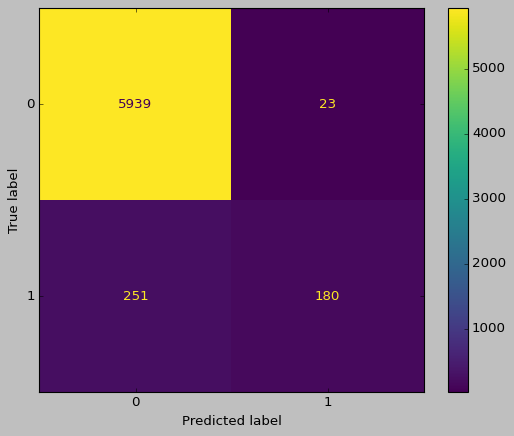

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.style as style

style.use('classic')
cm = confusion_matrix(y_test, y_pred_ensemble, labels=ensemble.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ensemble.classes_)
disp.plot()